## Imports

In [1]:
list_of_packages <- c(
       "ggplot2",
       "dplyr",
       "tidyr",
       "ComplexHeatmap",
       "tibble",
       "RColorBrewer",
       "scales",
       "circlize",
       "argparse"
)
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")

if (!requireNamespace("ComplexHeatmap", quietly = TRUE)) {
    BiocManager::install("ComplexHeatmap")
}
for (package in list_of_packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                package,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
# set custom colors for each MOA
custom_MOA_palette <- c(
    'BRD4 inhibitor' = "#93152A",  # Dark red
    'receptor tyrosine kinase inhibitor' = "#BA3924",  # Red
    'tyrosine kinase inhibitor' = "#D08543",  # Orange
    'MEK1/2 inhibitor' = "#A1961A",  # Yellow-green/olive

    'IGF-1R inhibitor' = "#9FC62A",  # Yellow-green
    'mTOR inhibitor' = "#1FAD23",  # Green
    'PI3K inhibitor' = "#32D06A",  # Light green
    'PI3K and HDAC inhibitor' = "#15937C",  # Teal/dark green
    'HDAC inhibitor' = "#24A5BA",  # Light blue/cyan

    'Apoptosis induction' = "#438CD0",  # Medium blue
    'DNA binding' = "#1A24A1",  # Dark blue
    'HSP90 inhibitor' = "#532AC6",  # Blue-purple

    'histamine H1 receptor antagonist' = "#AD1FA6",  # Purple/magenta
    'Na+/K+ pump inhibitor' = "#D03294",  # Pink/magenta

    'Control' = "#444444"  # Gray
)

In [3]:
# Get the current working directory and find Git root
find_git_root <- function() {
    # Get current working directory
    cwd <- getwd()
    
    # Check if current directory has .git
    if (dir.exists(file.path(cwd, ".git"))) {
        return(cwd)
    }
    
    # If not, search parent directories
    current_path <- cwd
    while (dirname(current_path) != current_path) {  # While not at root
        parent_path <- dirname(current_path)
        if (dir.exists(file.path(parent_path, ".git"))) {
            return(parent_path)
        }
        current_path <- parent_path
    }
    
    # If no Git root found, stop with error
    stop("No Git root directory found.")
}

# Find the Git root directory
root_dir <- find_git_root()
cat("Git root directory:", root_dir, "\n")

Git root directory: /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline 


## Pathing for files

In [4]:
sc_consensus_df <- arrow::read_parquet(file.path(root_dir,"data/all_patient_profiles/sc_consensus_profiles.parquet"))
sc_fs_df <- arrow::read_parquet(file.path(root_dir,"data/all_patient_profiles/sc_fs_profiles.parquet"))

# drop the therapeutic category column
sc_consensus_df <- sc_consensus_df %>%
  select(-`Therapeutic Categories`)
sc_fs_df <- sc_fs_df %>%
  select(-`Therapeutic Categories`)

organoid_consensus_df <- arrow::read_parquet(file.path(root_dir,"data/all_patient_profiles/organoid_consensus_profiles.parquet"))
organoid_fs_df <- arrow::read_parquet(file.path(root_dir,"data/all_patient_profiles/organoid_fs_profiles.parquet"))
# drop the therapeutic category column
organoid_consensus_df <- organoid_consensus_df %>%
  select(-`Therapeutic Categories`)
organoid_fs_df <- organoid_fs_df %>%
  select(-`Therapeutic Categories`)


sc_consensus_heatmap_file_path <- file.path(
    root_dir,
    paste0("5.EDA/figures/heatmaps/sc_consensus_heatmap.png")
)
sc_fs_heatmap_file_path <- file.path(
    root_dir,
    paste0("5.EDA/figures/heatmaps/sc_fs_heatmap.png")
)
organoid_consensus_heatmap_file_path <- file.path(
    root_dir,
    paste0("5.EDA/figures/heatmaps/organoid_consensus_heatmap.png")
)
organoid_fs_heatmap_file_path <- file.path(
    root_dir,
    paste0("5.EDA/figures/heatmaps/organoid_fs_heatmap.png")
)


if (!dir.exists(file.path(root_dir,paste0("5.EDA/figures/heatmaps/")))) {
    dir.create(file.path(root_dir,paste0("5.EDA/figures/heatmaps/")), recursive = TRUE)
}

In [5]:
patient_colors <- rainbow(length(unique(organoid_fs_df$patient)))
names(patient_colors) <- unique(organoid_fs_df$patient)
    

## Single-cell heatmap of consensus profiles

In [6]:
head(sc_consensus_df)

patient,treatment,dose,unit,Target,Class,Colocalization_Nuclei_AGP.BF_MEAN.CORRELATION.COEFF,Colocalization_Nuclei_AGP.BF_MEDIAN.OVERLAP.COEFF,Colocalization_Nuclei_AGP.BF_MIN.K1,Colocalization_Nuclei_AGP.BF_MEDIAN.K2,⋯,Texture_Cytoplasm_DNA_Sum.Variance_256.3,Texture_Cytoplasm_ER_Information.Measure.of.Correlation.1_256.3,Texture_Cytoplasm_ER_Sum.Average_256.3,Texture_Cytoplasm_ER_Sum.Variance_256.3,Texture_Cytoplasm_Mito_Angular.Second.Moment_256.3,Texture_Cytoplasm_Mito_Entropy_256.3,Texture_Cytoplasm_Mito_Sum.Average_256.3,Texture_Cytoplasm_Mito_Sum.Variance_256.3,Area.Size.Shape_Cytoplasm_EXTENT,Area.Size.Shape_Cytoplasm_EULER.NUMBER
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NF0014,Binimetinib,1,uM,MEK1/2 inhibitor,Small Molecule,-0.184286877,-0.2696301,-0.5546923,0.69828480,⋯,-0.6078762,0.81328001,-0.3207563,-0.6362506,0.16294736,-0.17587940,-0.30056008,-0.5775799,-0.2369790,0.6454788
NF0014,Binimetinib,10,uM,MEK1/2 inhibitor,Small Molecule,0.041784987,-0.2720046,-0.4280600,0.23078306,⋯,-0.2694585,0.16557612,-0.1905483,-0.4878529,0.10140500,-0.05436916,-0.09947429,-0.0911417,0.1752891,0.3543646
NF0014,Cabozantinib,1,uM,receptor tyrosine kinase inhibitor,Small Molecule,-0.127693596,-0.2718612,-0.2856468,-0.04076079,⋯,-0.4953348,-0.10436933,-0.2032715,-0.4849034,0.07571865,-0.08234846,-0.10150561,-0.1909708,0.1326024,0.7702421
NF0014,Copanlisib,1,uM,PI3K inhibitor,Small Molecule,0.129020724,-0.2718509,-0.6817242,0.90742841,⋯,-0.5379934,-0.28380462,-0.2394025,-0.5785306,0.12357408,-0.12976626,-0.23204146,-0.4355310,0.3662346,0.6870666
NF0014,DMSO,1,%,Control,Control,0.008679333,-0.2717297,-0.3745944,0.13414816,⋯,-0.2136145,-0.04903773,-0.1566772,-0.2470003,0.11821235,-0.13032451,-0.16721769,-0.2421911,-0.1109101,0.1048382
NF0014,Digoxin,1,uM,Na+/K+ pump inhibitor,Small Molecule,0.046008727,-0.2731856,-0.1678502,-0.29842884,⋯,-0.7669261,0.31327677,-0.3503632,-0.7361118,0.13633487,-0.13011232,-0.33137646,-0.7403713,0.7278250,0.8742114


In [7]:
# drop columns that contain neighbors
sc_consensus_df <- sc_consensus_df %>%
  select(-contains("Neighbors"))

In [8]:
column_anno <- HeatmapAnnotation(
    Target = sc_consensus_df$Target,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    col = list(
            Target = custom_MOA_palette
        )
)
patient_columns_anno <- HeatmapAnnotation(
    patient = sc_consensus_df$patient,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))

)

column_annotations = c(column_anno, patient_columns_anno)

In [9]:
# get the list of features
features <- colnames(sc_consensus_df)
features <- features[!features %in% c("treatment", "Target", "Class", "single_cell_count","patient","dose","unit")]
features <- as.data.frame(features)

rownames(features) <- features$features
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Feature Type", "Compartment", "Channel", "Measurement"), sep = "_", extra = "merge", fill = "right")
# if Feature type is AreaSizeShape then shift the Channel to the Measurement column and set Channel to NA
features <- features %>%
    mutate(
        Measurement = ifelse(`Feature Type` == "Area.Size.Shape", Channel, Measurement)
    )
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Area.Size.Shape", "None", Channel)
    )

# select the first channel for colocalization features channels are split by .
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Colocalization", 
                         sub("\\..*", "", Channel), 
                         Channel)
    )


# sort by feature type
features <- features %>%
    arrange(`Feature Type`, Compartment, Channel, Measurement)

In [10]:
# compartment row annotation
row_compartment = rowAnnotation(
    Object = features$Compartment,
        show_legend = TRUE,
    # change the legend titles
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    # color
    col = list(
        Object = c(
            "Cell" = "#B000B0", 
            "Cytoplasm" = "#00D55B", 
            "Nuclei" = "#0000AB"
            )
    )
)
row_measurement = rowAnnotation(
    FeatureType = features$`Feature Type`,
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            FeatureType = c(
            "Area.Size.Shape" = brewer.pal(8, "Paired")[1],
            "Colocalization" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        # legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        # legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "AGP" = "#b1001a",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "BF" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_compartment, row_measurement, row_channel)

In [11]:
mat <- sc_consensus_df %>%
  select(-treatment, -Class, -Target,-patient,-dose,-unit) %>%
  
  as.matrix()
mat <- t(mat)
colnames(mat) <- sc_consensus_df$treatment
dim(mat)

[1] 317 156

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



png 
  2

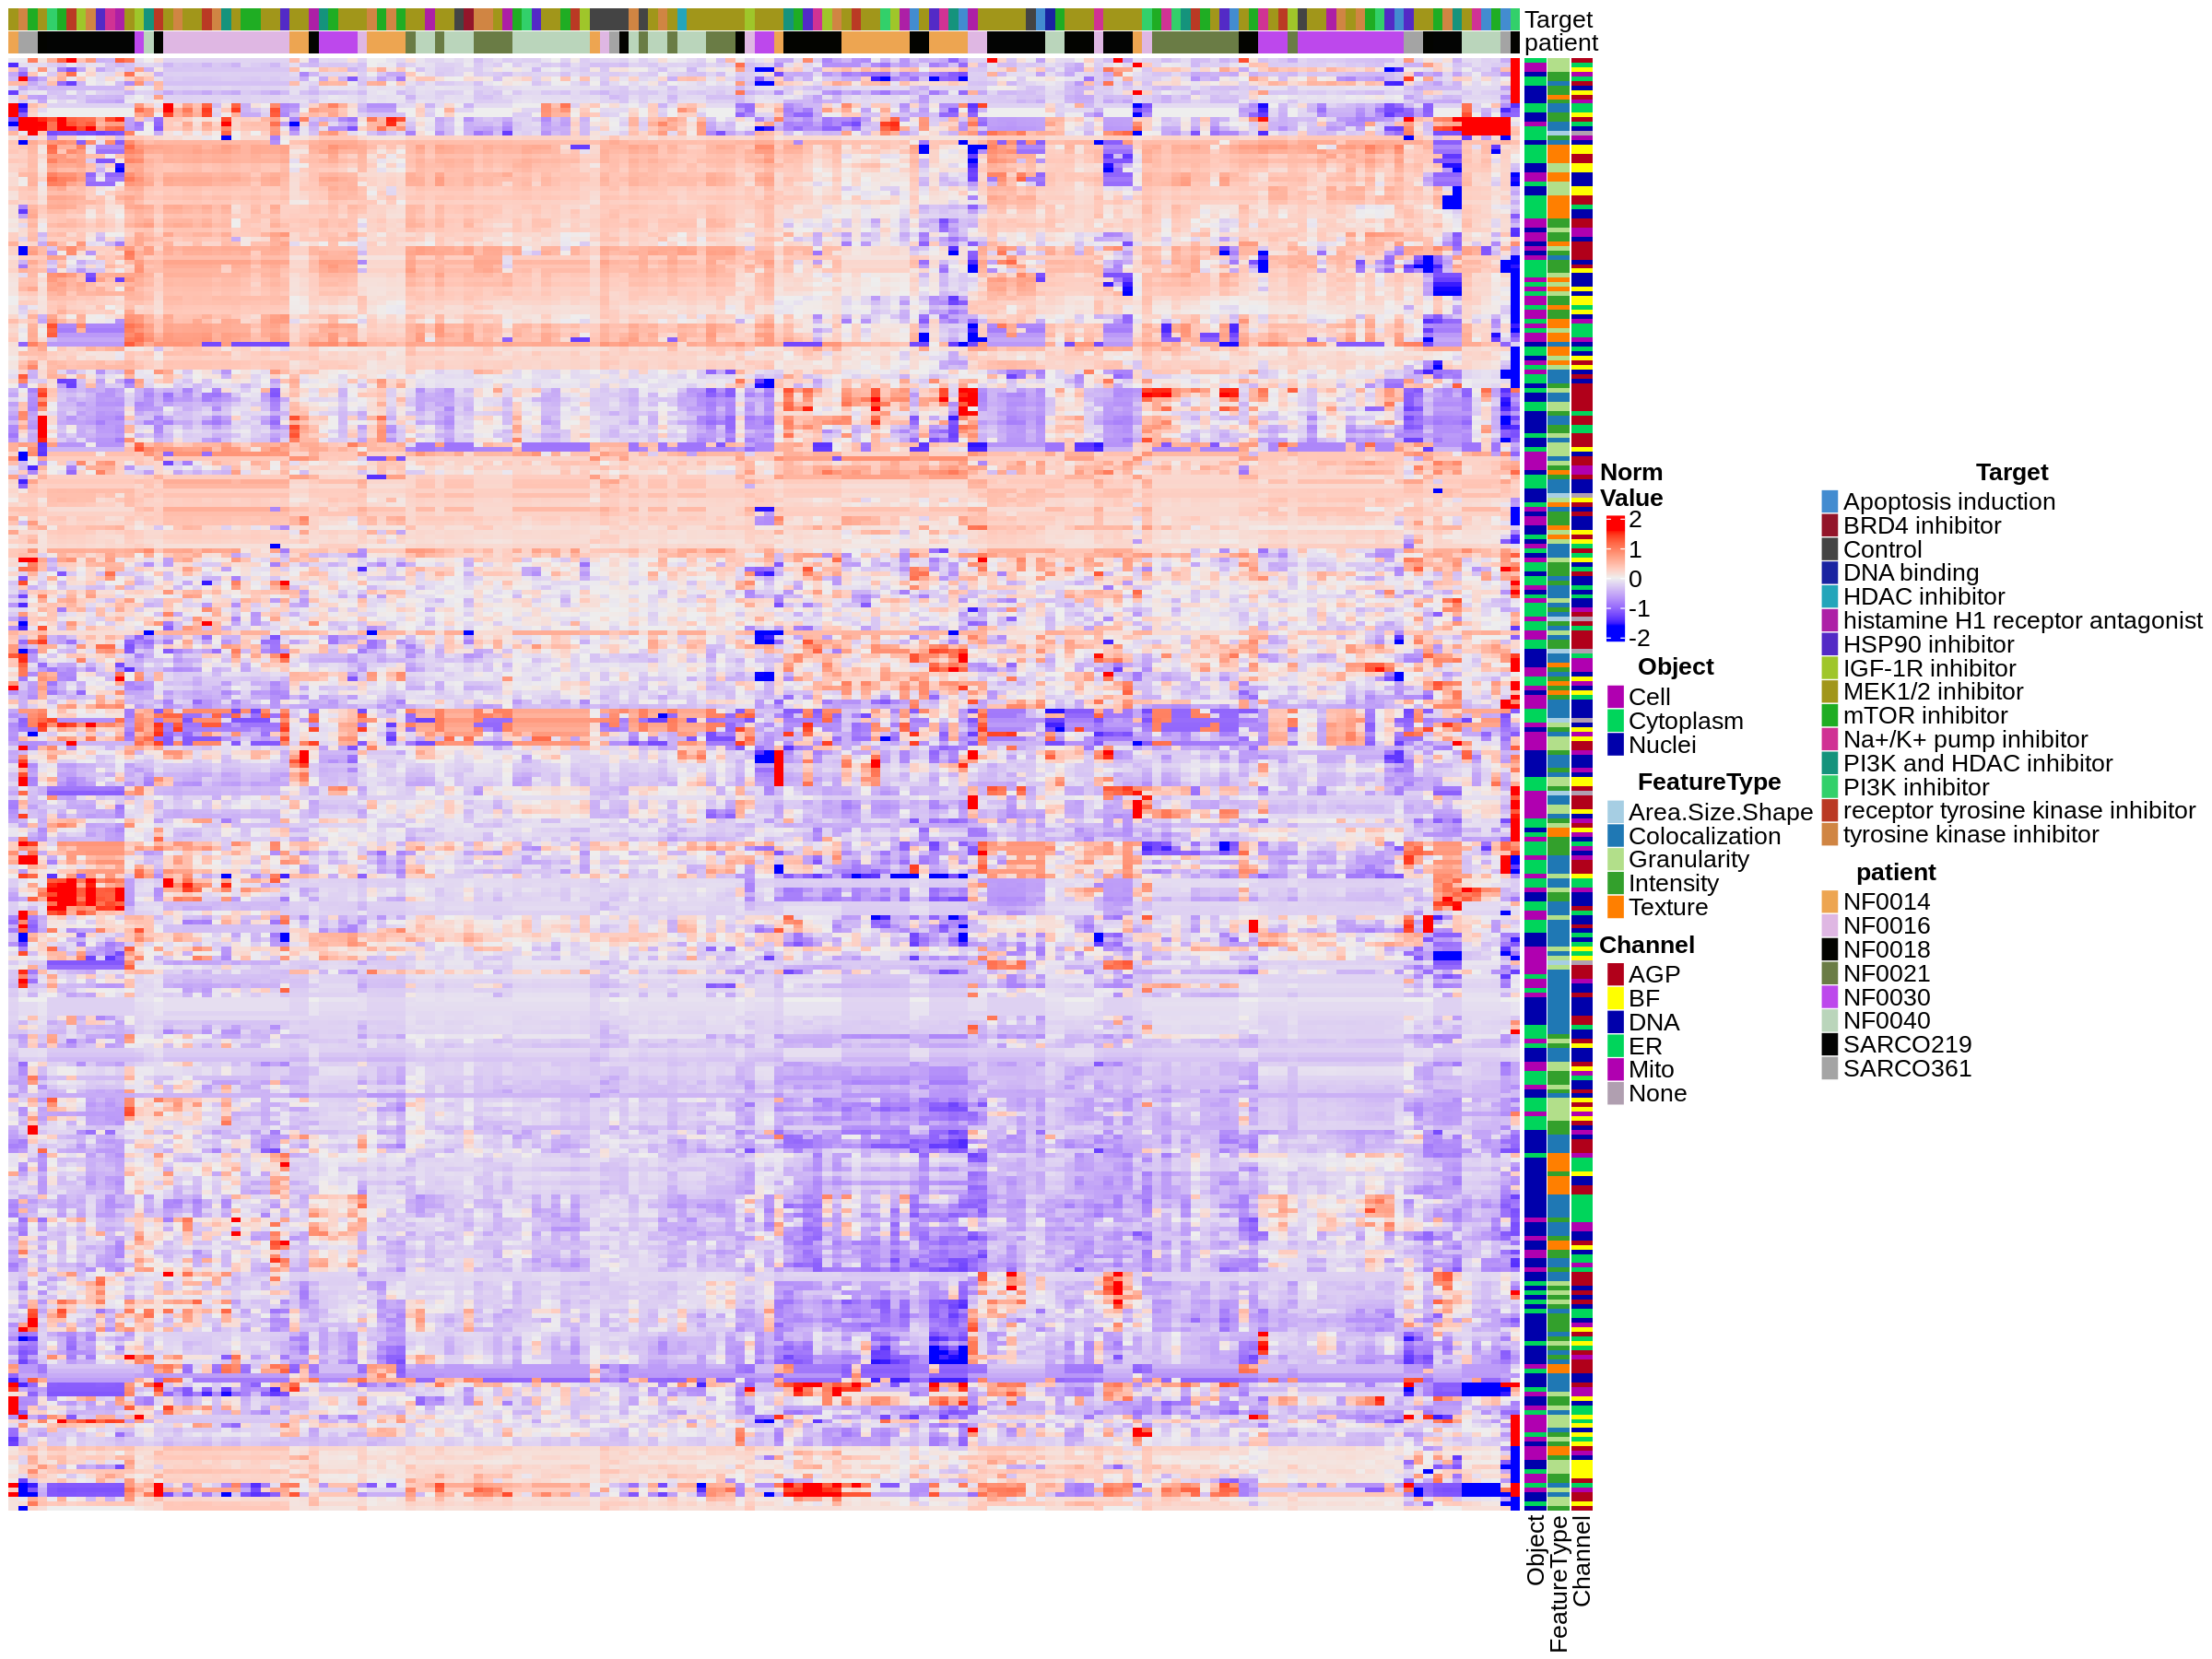

In [12]:
width <- 20
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
heatmap_plot <- Heatmap(
        mat, 
        # col = col_fun,
        show_row_names = FALSE,
        # cluster_columns = FALSE,
        show_column_names = FALSE,
        row_dend_reorder = TRUE, # reorder rows based on dendrogram
        column_dend_reorder = TRUE, # reorder columns based on dendrogram
        show_row_dend = FALSE,
        show_column_dend = FALSE,

        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14), 

        # show_heatmap_legend = FALSE,
        heatmap_legend_param = list(
                    title = "Norm\nValue",
                    title_position = "topcenter", 
                    title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                    labels_gp = gpar(fontsize = 16),
                    # legend_height = unit(2, "cm"),
                    legend_width = unit(3, "cm"),
                    annotation_legend_side = "bottom"
                    ), 
        
        row_dend_width = unit(1, "cm"),
        column_dend_height = unit(1, "cm"),
        
        # column_title = paste0("Dose: ", dose," uM"),
        right_annotation = row_annotations,
        top_annotation = column_annotations,
        # adjust the title position and size
        column_title_gp = gpar(fontsize = 16, fontface = "bold", hjust = 0.5),
    
    )

png(sc_consensus_heatmap_file_path, width = width, height = height, units = "in", res = 600)
# save as a PNG
draw(heatmap_plot, merge_legend = TRUE, heatmap_legend_side = "right")
dev.off()
heatmap_plot

## Single-cell heatmap of sc fs profiles

In [13]:
head(sc_fs_df)


patient,object_id,unit,dose,treatment,Target,Class,image_set,Well,parent_organoid,⋯,Texture_Cytoplasm_DNA_Sum.Variance_256.3,Texture_Cytoplasm_ER_Information.Measure.of.Correlation.1_256.3,Texture_Cytoplasm_ER_Sum.Average_256.3,Texture_Cytoplasm_ER_Sum.Variance_256.3,Texture_Cytoplasm_Mito_Angular.Second.Moment_256.3,Texture_Cytoplasm_Mito_Entropy_256.3,Texture_Cytoplasm_Mito_Sum.Average_256.3,Texture_Cytoplasm_Mito_Sum.Variance_256.3,Area.Size.Shape_Cytoplasm_EXTENT,Area.Size.Shape_Cytoplasm_EULER.NUMBER
<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NF0014,25,uM,10,Mirdametinib,MEK1/2 inhibitor,Small Molecule,G8-1,G8,40,⋯,-0.64469007,0.01008931,-0.2288176,-0.6211718,0.0385905249,0.033898969,0.009684509,0.13266921,-0.9651855,-0.39421474
NF0014,51,uM,10,Mirdametinib,MEK1/2 inhibitor,Small Molecule,G8-1,G8,40,⋯,-0.38245990,-0.66286685,-0.1106348,-0.4115443,-0.0007639116,0.093548409,0.078748338,0.19721140,-0.5293255,-0.81009217
NF0014,76,uM,10,Mirdametinib,MEK1/2 inhibitor,Small Molecule,G8-1,G8,40,⋯,0.03260092,-0.32955361,-0.2118098,-0.5473245,0.0684573284,-0.007521941,-0.067182591,-0.02575399,-0.1015080,-0.06151279
NF0014,102,uM,10,Mirdametinib,MEK1/2 inhibitor,Small Molecule,G8-1,G8,40,⋯,-0.71620439,0.08953078,-0.2985152,-0.5726059,0.1790532327,-0.193309657,-0.320329056,-0.50271552,-0.1316953,-0.10310053
NF0014,127,uM,10,Mirdametinib,MEK1/2 inhibitor,Small Molecule,G8-1,G8,40,⋯,-0.46195880,-0.81841918,-0.2307978,-0.4938437,0.1287358820,-0.108998656,-0.181595903,-0.22487924,0.5841691,-0.85167992
NF0014,178,uM,10,Mirdametinib,MEK1/2 inhibitor,Small Molecule,G8-1,G8,40,⋯,-0.48346141,-0.15830240,-0.2902233,-0.5677577,0.1718879210,-0.180389669,-0.276321474,-0.36108478,0.2810660,-0.39421474


In [14]:
# drop columns that contain neighbors
sc_fs_df <- sc_fs_df %>%
  select(-contains("Neighbors"))

In [15]:
column_anno <- HeatmapAnnotation(
    Target = sc_fs_df$Target,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    col = list(
            Target = custom_MOA_palette
        )
)

patient_colors <- rainbow(length(unique(sc_fs_df$patient)))
names(patient_colors) <- unique(sc_fs_df$patient)

patient_columns_anno <- HeatmapAnnotation(
    Patient = sc_fs_df$patient,
    col = list(Patient = patient_colors),
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))
)

column_annotations = c(column_anno, patient_columns_anno)


In [16]:
# get the list of features
features <- colnames(sc_fs_df)
features <- features[!features %in% c("treatment", "Target", "Class", "single_cell_count", "patient",
         "object_id",
         "unit",
         "dose",
         "image_set",
         "Well",
         "parent_organoid")]
features <- as.data.frame(features)
rownames(features) <- features$features
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Feature Type", "Compartment", "Channel", "Measurement"), sep = "_", extra = "merge", fill = "right")
# if Feature type is AreaSizeShape then shift the Channel to the Measurement column and set Channel to NA
features <- features %>%
    mutate(
        Measurement = ifelse(`Feature Type` == "Area.Size.Shape", Channel, Measurement)
    )
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Area.Size.Shape", "None", Channel)
    )

# select the first channel for colocalization features channels are split by .
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Colocalization", 
                         sub("\\..*", "", Channel), 
                         Channel)
    )


# sort by feature type
features <- features %>%
    arrange(`Feature Type`, Compartment, Channel, Measurement)

In [17]:
# compartment row annotation
row_compartment = rowAnnotation(
    Object = features$Compartment,
        show_legend = TRUE,
    # change the legend titles
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    # color
    col = list(
        Object = c(
            "Cell" = "#B000B0", 
            "Cytoplasm" = "#00D55B", 
            "Nuclei" = "#0000AB"
            )
    )
)
row_measurement = rowAnnotation(
    FeatureType = features$`Feature Type`,
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            FeatureType = c(
            "Area.Size.Shape" = brewer.pal(8, "Paired")[1],
            "Colocalization" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        # legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        # legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "AGP" = "#b1001a",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "BF" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_compartment, row_measurement, row_channel)

In [18]:
mat <- sc_fs_df %>%
  select(-treatment, -Class, -Target, -patient,
        -object_id,
         -unit,
         -dose,
         -image_set,
         -Well,
         -parent_organoid) %>%
  
  as.matrix()
mat <- t(mat)
colnames(mat) <- sc_fs_df$treatment
dim(mat)

[1]  317 9870

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

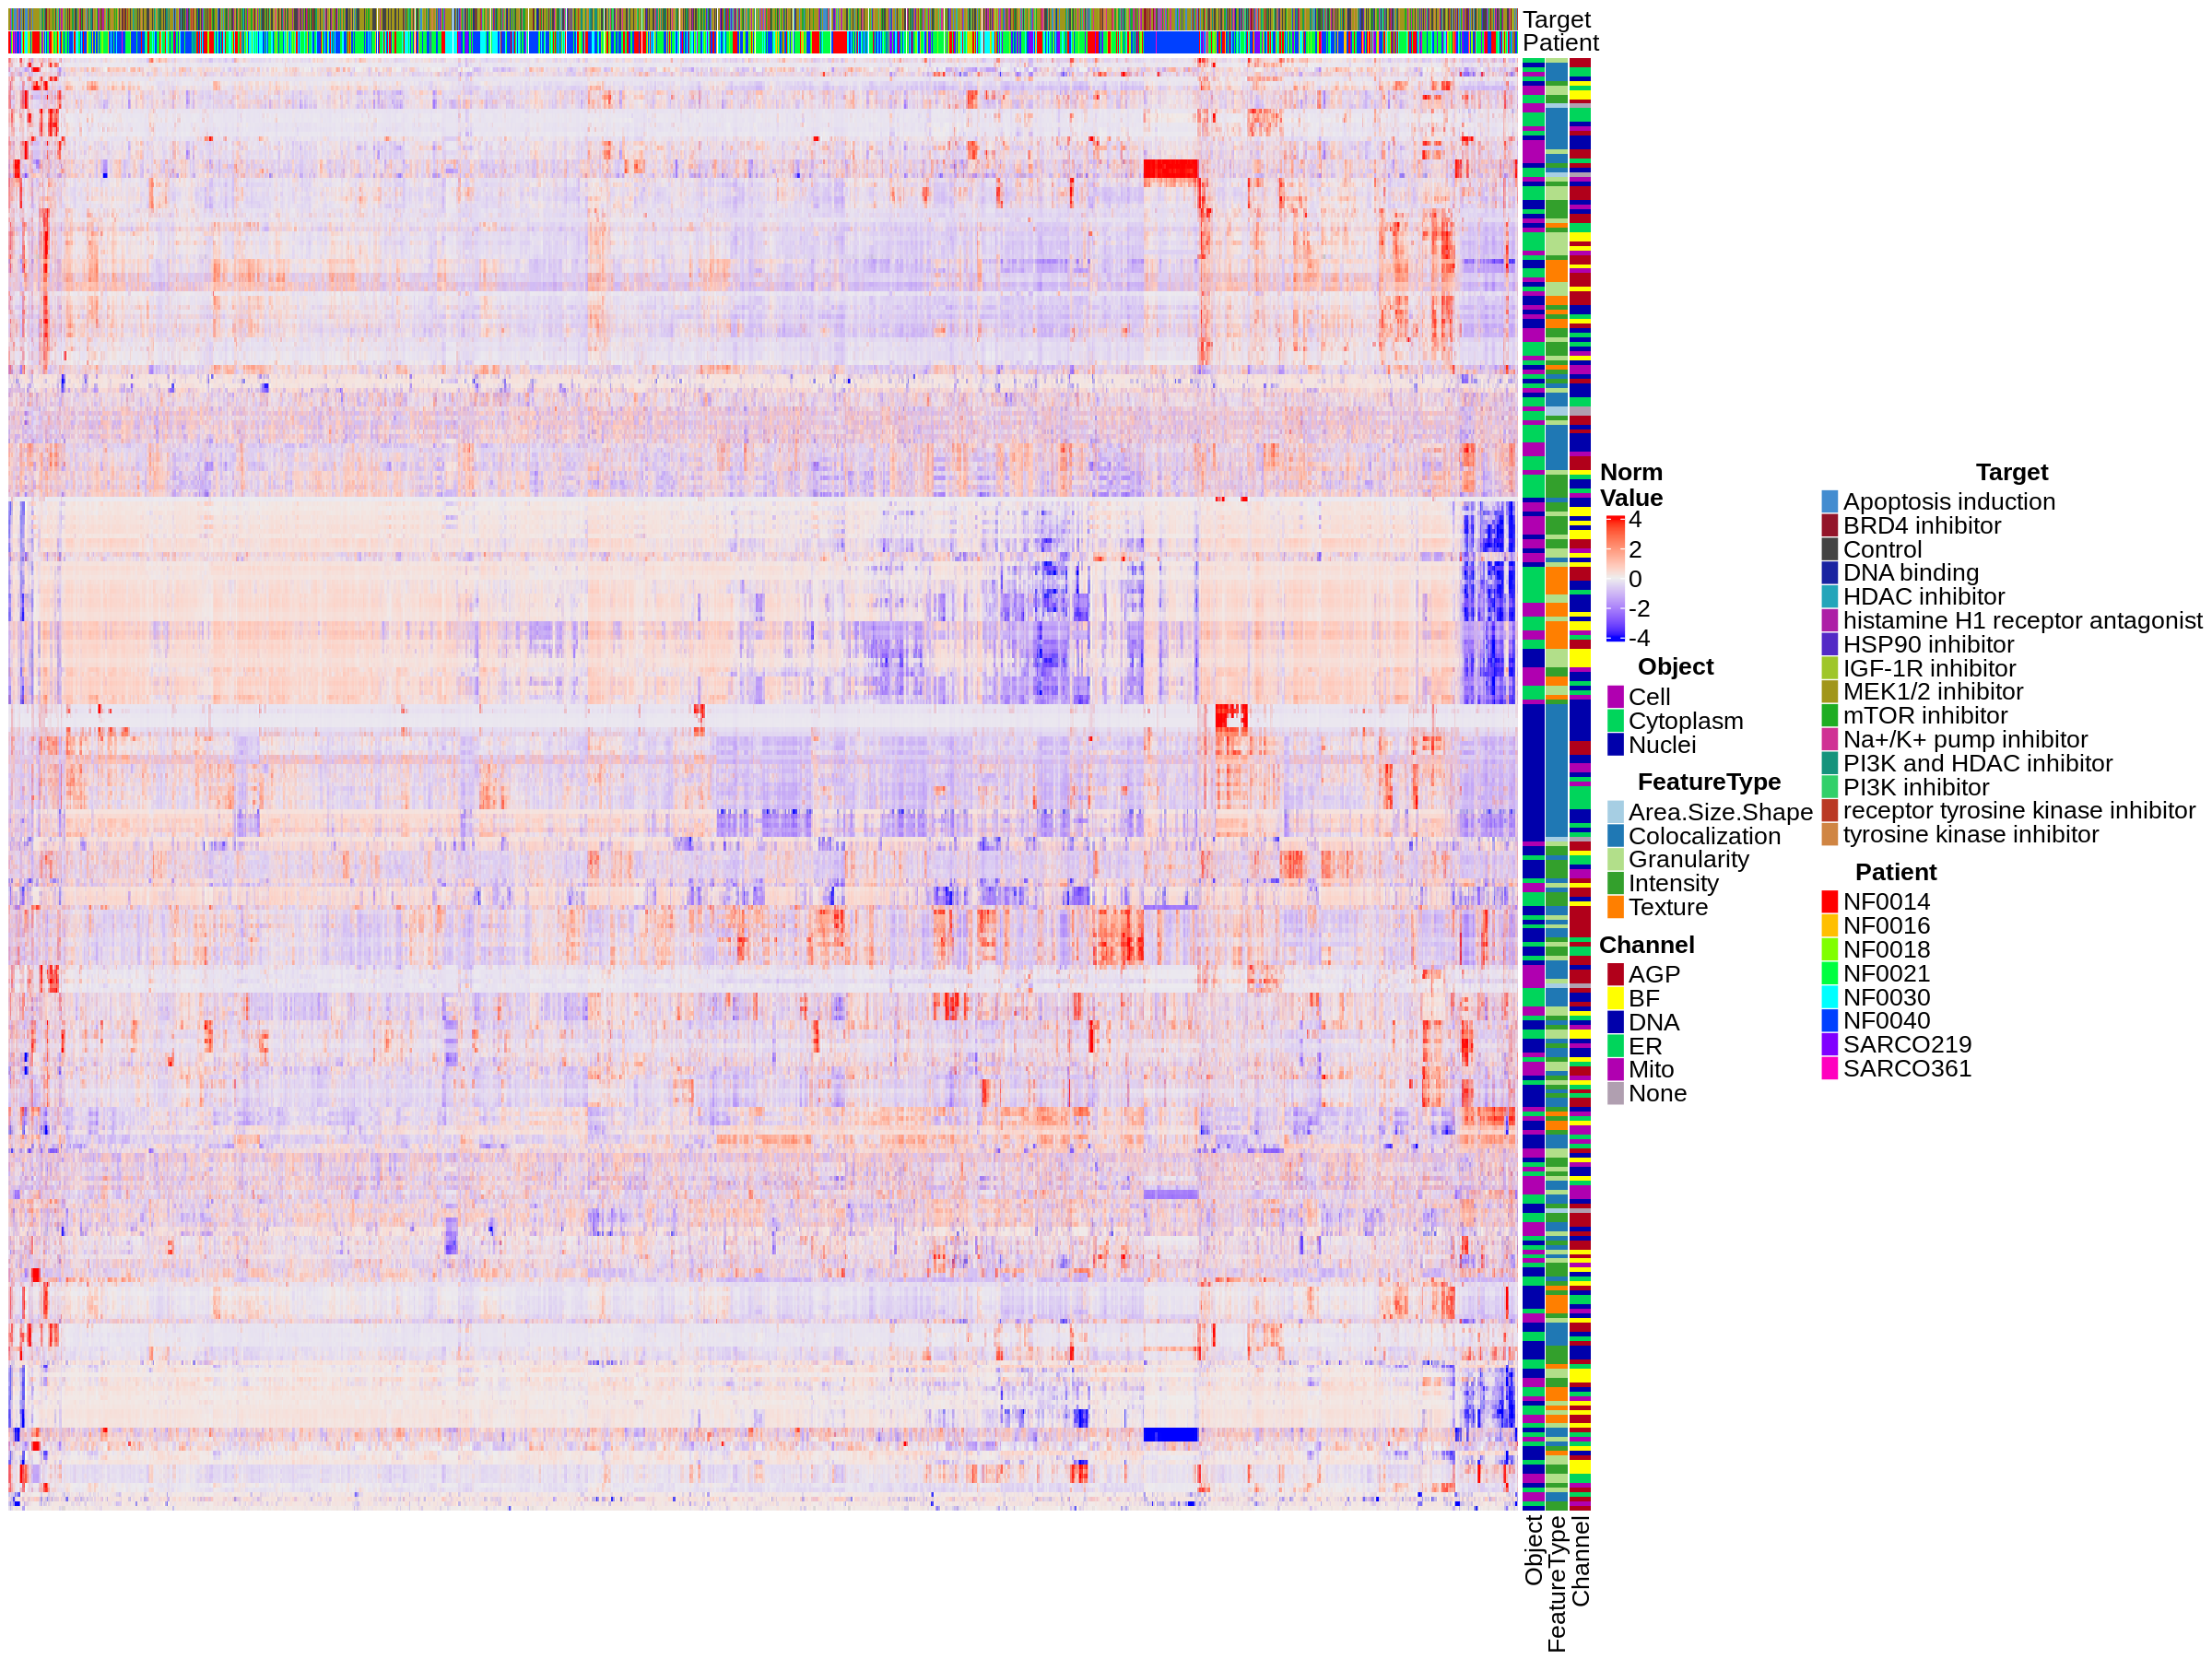

In [19]:
width <- 20
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
heatmap_plot <- Heatmap(
        mat, 
        # col = col_fun,
        show_row_names = FALSE,
        # cluster_columns = FALSE,
        show_column_names = FALSE,
        row_dend_reorder = TRUE, # reorder rows based on dendrogram
        column_dend_reorder = TRUE, # reorder columns based on dendrogram
        show_row_dend = FALSE,
        show_column_dend = FALSE,

        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14), 

        # show_heatmap_legend = FALSE,
        heatmap_legend_param = list(
                    title = "Norm\nValue",
                    title_position = "topcenter", 
                    title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                    labels_gp = gpar(fontsize = 16),
                    # legend_height = unit(2, "cm"),
                    legend_width = unit(3, "cm"),
                    annotation_legend_side = "bottom"
                    ), 
        
        row_dend_width = unit(4, "cm"),
        column_dend_height = unit(4, "cm"),
        # column_title = paste0("Dose: ", dose," uM"),
        right_annotation = row_annotations,
        top_annotation = column_annotations,
        # adjust the title position and size
        column_title_gp = gpar(fontsize = 16, fontface = "bold", hjust = 0.5),
    
    )
png(sc_fs_heatmap_file_path, width = width, height = height, units = "in", res = 600)
# save as a PNG
draw(heatmap_plot, merge_legend = TRUE, heatmap_legend_side = "right")
dev.off()
heatmap_plot

## Organoid heatmap of consensus profiles

In [20]:
head(organoid_consensus_df)

patient,treatment,dose,unit,Target,Class,Colocalization_Organoid_AGP.BF_MEDIAN.CORRELATION.COEFF,Colocalization_Organoid_AGP.BF_MAX.MANDERS.COEFF.M2,Colocalization_Organoid_AGP.BF_MEAN.OVERLAP.COEFF,Colocalization_Organoid_AGP.BF_MEAN.K2,⋯,Texture_Organoid_ER_Contrast_256.3,Texture_Organoid_ER_Information.Measure.of.Correlation.2_256.3,Texture_Organoid_ER_Sum.Average_256.3,Texture_Organoid_ER_Variance_256.3,Texture_Organoid_Mito_Contrast_256.3,Texture_Organoid_Mito_Sum.Average_256.3,Texture_Organoid_Mito_Variance_256.3,Area.Size.Shape_Organoid_EXTENT,Area.Size.Shape_Organoid_EULER.NUMBER,Area.Size.Shape_Organoid_SURFACE.AREA
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NF0014,Binimetinib,1,uM,MEK1/2 inhibitor,Small Molecule,0.2501474,-0.95896255,-0.93358445,0.73477984,⋯,-0.5419167,-0.96244505,-1.1548391,-0.9579401,0.05826345,-0.5136133,-0.1974620,-0.75341735,-0.2960704,-0.7737309
NF0014,Binimetinib,10,uM,MEK1/2 inhibitor,Small Molecule,-0.5282621,0.08586530,-0.96028678,0.91788047,⋯,-0.5517376,-2.50049987,-1.0816036,-0.9025234,-0.71989968,-0.8146268,-0.3414513,0.74337630,-0.4088304,-1.3673196
NF0014,Cabozantinib,1,uM,receptor tyrosine kinase inhibitor,Small Molecule,0.1597416,-0.64064094,-0.86665756,0.08570623,⋯,-0.2911755,-0.78977618,-0.6857140,-0.6729403,-0.31720371,-0.4620224,-0.1336881,0.17501886,-0.4088304,-1.0556796
NF0014,Copanlisib,1,uM,PI3K inhibitor,Small Molecule,0.2604506,-1.06708032,-0.95006171,0.36197497,⋯,-0.2704968,-1.43689413,-0.9617208,-0.7605898,0.53353062,-0.6605660,-0.3063693,-0.42659080,-0.3883285,-1.1374567
NF0014,DMSO,1,%,Control,Control,0.4938911,0.09903665,0.06249213,-0.12649450,⋯,-0.3987118,0.01222531,-0.2914359,-0.3589357,-0.30694942,-0.2155743,-0.4293686,-0.07543949,-0.4088304,-0.4588865
NF0014,Digoxin,1,uM,Na+/K+ pump inhibitor,Small Molecule,0.5252740,-2.14148296,-1.22079085,1.42696349,⋯,-0.5610131,-1.16276514,-1.1394080,-0.9583440,-0.32305449,-1.1777979,-0.9938126,-0.21822492,-0.3883285,-1.2838415


In [21]:
# drop columns that contain neighbors
organoid_consensus_df <- organoid_consensus_df %>%
  select(-contains("Neighbors"))

In [22]:
column_anno <- HeatmapAnnotation(
    Target = organoid_consensus_df$Target,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    col = list(
            Target = custom_MOA_palette
        )
)
patient_columns_anno <- HeatmapAnnotation(
    patient = organoid_consensus_df$patient,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))

)

column_annotations = c(column_anno, patient_columns_anno)

In [23]:
head(organoid_consensus_df)

patient,treatment,dose,unit,Target,Class,Colocalization_Organoid_AGP.BF_MEDIAN.CORRELATION.COEFF,Colocalization_Organoid_AGP.BF_MAX.MANDERS.COEFF.M2,Colocalization_Organoid_AGP.BF_MEAN.OVERLAP.COEFF,Colocalization_Organoid_AGP.BF_MEAN.K2,⋯,Texture_Organoid_ER_Contrast_256.3,Texture_Organoid_ER_Information.Measure.of.Correlation.2_256.3,Texture_Organoid_ER_Sum.Average_256.3,Texture_Organoid_ER_Variance_256.3,Texture_Organoid_Mito_Contrast_256.3,Texture_Organoid_Mito_Sum.Average_256.3,Texture_Organoid_Mito_Variance_256.3,Area.Size.Shape_Organoid_EXTENT,Area.Size.Shape_Organoid_EULER.NUMBER,Area.Size.Shape_Organoid_SURFACE.AREA
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NF0014,Binimetinib,1,uM,MEK1/2 inhibitor,Small Molecule,0.2501474,-0.95896255,-0.93358445,0.73477984,⋯,-0.5419167,-0.96244505,-1.1548391,-0.9579401,0.05826345,-0.5136133,-0.1974620,-0.75341735,-0.2960704,-0.7737309
NF0014,Binimetinib,10,uM,MEK1/2 inhibitor,Small Molecule,-0.5282621,0.08586530,-0.96028678,0.91788047,⋯,-0.5517376,-2.50049987,-1.0816036,-0.9025234,-0.71989968,-0.8146268,-0.3414513,0.74337630,-0.4088304,-1.3673196
NF0014,Cabozantinib,1,uM,receptor tyrosine kinase inhibitor,Small Molecule,0.1597416,-0.64064094,-0.86665756,0.08570623,⋯,-0.2911755,-0.78977618,-0.6857140,-0.6729403,-0.31720371,-0.4620224,-0.1336881,0.17501886,-0.4088304,-1.0556796
NF0014,Copanlisib,1,uM,PI3K inhibitor,Small Molecule,0.2604506,-1.06708032,-0.95006171,0.36197497,⋯,-0.2704968,-1.43689413,-0.9617208,-0.7605898,0.53353062,-0.6605660,-0.3063693,-0.42659080,-0.3883285,-1.1374567
NF0014,DMSO,1,%,Control,Control,0.4938911,0.09903665,0.06249213,-0.12649450,⋯,-0.3987118,0.01222531,-0.2914359,-0.3589357,-0.30694942,-0.2155743,-0.4293686,-0.07543949,-0.4088304,-0.4588865
NF0014,Digoxin,1,uM,Na+/K+ pump inhibitor,Small Molecule,0.5252740,-2.14148296,-1.22079085,1.42696349,⋯,-0.5610131,-1.16276514,-1.1394080,-0.9583440,-0.32305449,-1.1777979,-0.9938126,-0.21822492,-0.3883285,-1.2838415


In [24]:
# get the list of features
features <- colnames(organoid_consensus_df)
features <- features[!features %in% c("treatment", "Target", "Class", "single_cell_count","patient","dose","unit")]
features <- as.data.frame(features)

rownames(features) <- features$features
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Feature Type", "Compartment", "Channel", "Measurement"), sep = "_", extra = "merge", fill = "right")
# if Feature type is AreaSizeShape then shift the Channel to the Measurement column and set Channel to NA
features <- features %>%
    mutate(
        Measurement = ifelse(`Feature Type` == "Area.Size.Shape", Channel, Measurement)
    )
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Area.Size.Shape", "None", Channel)
    )

# select the first channel for colocalization features channels are split by .
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Colocalization", 
                         sub("\\..*", "", Channel), 
                         Channel)
    )


# sort by feature type
features <- features %>%
    arrange(`Feature Type`, Compartment, Channel, Measurement)

In [25]:
row_measurement = rowAnnotation(
    FeatureType = features$`Feature Type`,
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            FeatureType = c(
            "Area.Size.Shape" = brewer.pal(8, "Paired")[1],
            "Colocalization" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        # legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        # legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "AGP" = "#b1001a",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "BF" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_measurement, row_channel)

In [26]:
mat <- organoid_consensus_df %>%
  select(-treatment, -Class, -Target,-patient,-dose,-unit) %>%

  as.matrix()
mat <- t(mat)
colnames(mat) <- organoid_consensus_df$treatment
dim(mat)

[1] 164 157

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



png 
  2

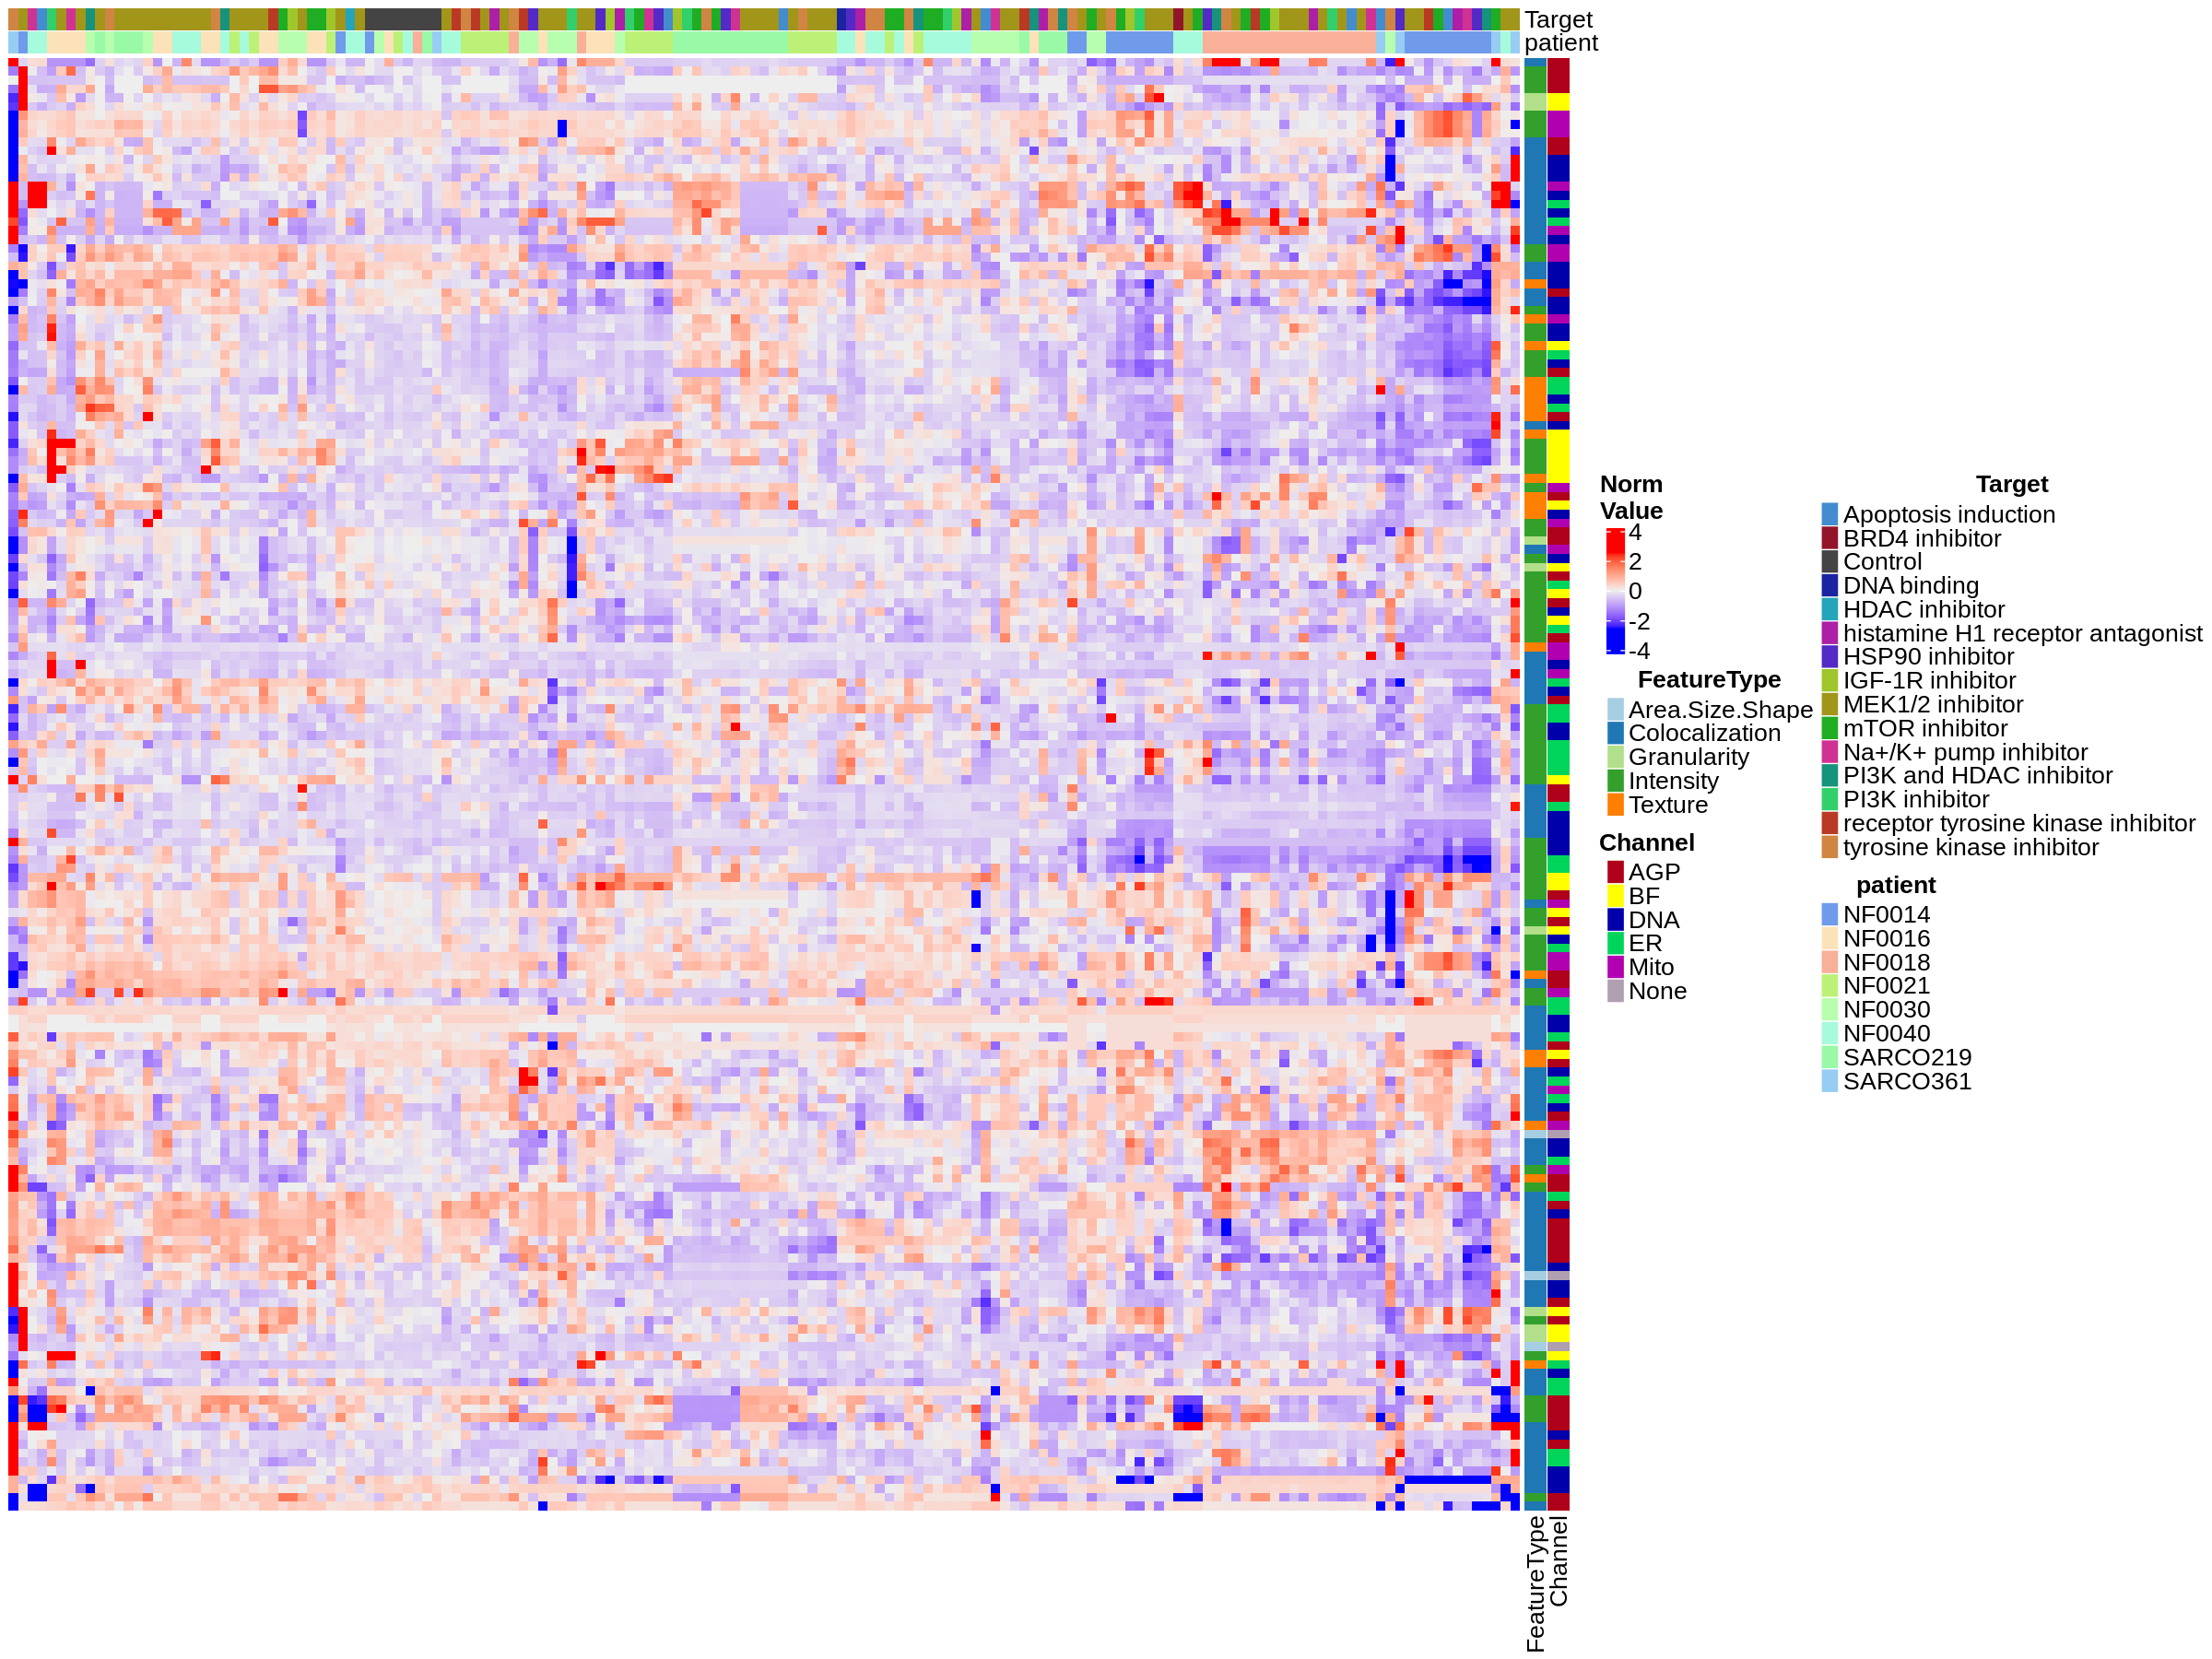

In [27]:
width <- 20
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
heatmap_plot <- Heatmap(
        mat, 
        # col = col_fun,
        show_row_names = FALSE,
        # cluster_columns = FALSE,
        show_column_names = FALSE,
        row_dend_reorder = TRUE, # reorder rows based on dendrogram
        column_dend_reorder = TRUE, # reorder columns based on dendrogram
        show_row_dend = FALSE,
        show_column_dend = FALSE,

        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14), 

        # show_heatmap_legend = FALSE,
        heatmap_legend_param = list(
                    title = "Norm\nValue",
                    title_position = "topcenter", 
                    title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                    labels_gp = gpar(fontsize = 16),
                    # legend_height = unit(2, "cm"),
                    legend_width = unit(3, "cm"),
                    annotation_legend_side = "bottom"
                    ), 
        
        row_dend_width = unit(1, "cm"),
        column_dend_height = unit(1, "cm"),
        
        # column_title = paste0("Dose: ", dose," uM"),
        right_annotation = row_annotations,
        top_annotation = column_annotations,
        # adjust the title position and size
        column_title_gp = gpar(fontsize = 16, fontface = "bold", hjust = 0.5),
    
    )

png(organoid_consensus_heatmap_file_path, width = width, height = height, units = "in", res = 600)
# save as a PNG
draw(heatmap_plot, merge_legend = TRUE, heatmap_legend_side = "right")
dev.off()
heatmap_plot

## Organoid heatmap of sc fs profiles

In [28]:
head(organoid_fs_df)


patient,object_id,unit,dose,treatment,Target,Class,image_set,Well,single_cell_count,⋯,Texture_Organoid_ER_Contrast_256.3,Texture_Organoid_ER_Information.Measure.of.Correlation.2_256.3,Texture_Organoid_ER_Sum.Average_256.3,Texture_Organoid_ER_Variance_256.3,Texture_Organoid_Mito_Contrast_256.3,Texture_Organoid_Mito_Sum.Average_256.3,Texture_Organoid_Mito_Variance_256.3,Area.Size.Shape_Organoid_EXTENT,Area.Size.Shape_Organoid_EULER.NUMBER,Area.Size.Shape_Organoid_SURFACE.AREA
<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NF0014,40,uM,10,Mirdametinib,MEK1/2 inhibitor,Small Molecule,G8-1,G8,8,⋯,-0.53214961,-3.104159,-1.1787997,-0.8844659,-0.9769376,-1.3806942,-0.9866679,-1.6647402,-0.4088304,-1.0074538
NF0014,24,uM,1,Fimepinostat,PI3K and HDAC inhibitor,Small Molecule,D5-1,D5,5,⋯,0.04700485,-9.397373,-1.1881627,-0.9960632,1.5564946,-1.4852353,-1.0633384,-2.4840728,-0.3268231,1.0415423
NF0014,85,uM,1,Mirdametinib,MEK1/2 inhibitor,Small Molecule,F8-1,F8,9,⋯,0.14473062,1.123636,0.7801972,-0.3664356,-0.9956813,-0.9224064,-1.1909291,-0.6631291,-0.1423067,0.2489196
NF0014,18,nM,10,Staurosporine,Apoptosis induction,Small Molecule,G11-1,G11,1,⋯,-0.67019131,-3.467519,-1.5231079,-1.0602031,-0.5375273,-1.1937030,-0.7253987,0.2653725,-0.4088304,-1.5156439
NF0014,24,uM,1,Binimetinib,MEK1/2 inhibitor,Small Molecule,G7-1,G7,7,⋯,-0.64604129,-1.304901,-1.2737328,-1.0079539,-0.3233302,-0.3678275,0.0728355,-0.3695564,-0.4088304,-1.3020486
NF0014,30,uM,1,Copanlisib,PI3K inhibitor,Small Molecule,E3-2,E3,9,⋯,-0.46154944,-2.655016,-0.9591636,-0.6654503,-0.5936876,-0.9324702,-0.2433724,0.7245801,-0.4088304,-1.3489222


In [29]:
# drop columns that contain neighbors
organoid_fs_df <- organoid_fs_df %>%
  select(-contains("Neighbors")) %>%
  select(-contains("single_cell_count"))

In [30]:
dim(organoid_fs_df)
# drop all rows that have any NA values
organoid_fs_df <- organoid_fs_df %>%
  filter(complete.cases(.))
dim(organoid_fs_df)

[1] 1282  173

[1] 1233  173

In [31]:
column_anno <- HeatmapAnnotation(
    Target = organoid_fs_df$Target,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    col = list(
            Target = custom_MOA_palette
        )
)

patient_columns_anno <- HeatmapAnnotation(
    Patient = organoid_fs_df$patient,
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 16),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16)))
)

column_annotations = c(column_anno, patient_columns_anno)


In [32]:
# get the list of features
features <- colnames(organoid_fs_df)
features <- features[!features %in% c("treatment", "Target", "Class", "single_cell_count", "patient",
         "object_id",
         "unit",
         "dose",
         "image_set",
         "Well",
         "single_cell_count")]
features <- as.data.frame(features)
rownames(features) <- features$features
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Feature Type", "Compartment", "Channel", "Measurement"), sep = "_", extra = "merge", fill = "right")
# if Feature type is AreaSizeShape then shift the Channel to the Measurement column and set Channel to NA
features <- features %>%
    mutate(
        Measurement = ifelse(`Feature Type` == "Area.Size.Shape", Channel, Measurement)
    )
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Area.Size.Shape", "None", Channel)
    )

# select the first channel for colocalization features channels are split by .
features <- features %>%
    mutate(
        Channel = ifelse(`Feature Type` == "Colocalization", 
                         sub("\\..*", "", Channel), 
                         Channel)
    )


# sort by feature type
features <- features %>%
    arrange(`Feature Type`, Compartment, Channel, Measurement)

In [33]:
row_measurement = rowAnnotation(
    FeatureType = features$`Feature Type`,
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "bottom",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            FeatureType = c(
            "Area.Size.Shape" = brewer.pal(8, "Paired")[1],
            "Colocalization" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        # legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        # legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "AGP" = "#b1001a",
            "Mito" = "#B000B0",
            "ER" = "#00D55B",
            "BF" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_measurement, row_channel)

In [34]:
mat <- organoid_fs_df %>%
  select(-treatment, -Class, -Target, -patient, -object_id, -image_set, -Well,
         -unit,
         -dose) %>%
  
  as.matrix()
mat <- t(mat)
colnames(mat) <- organoid_fs_df$treatment
dim(mat)

[1]  164 1233

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



png 
  2

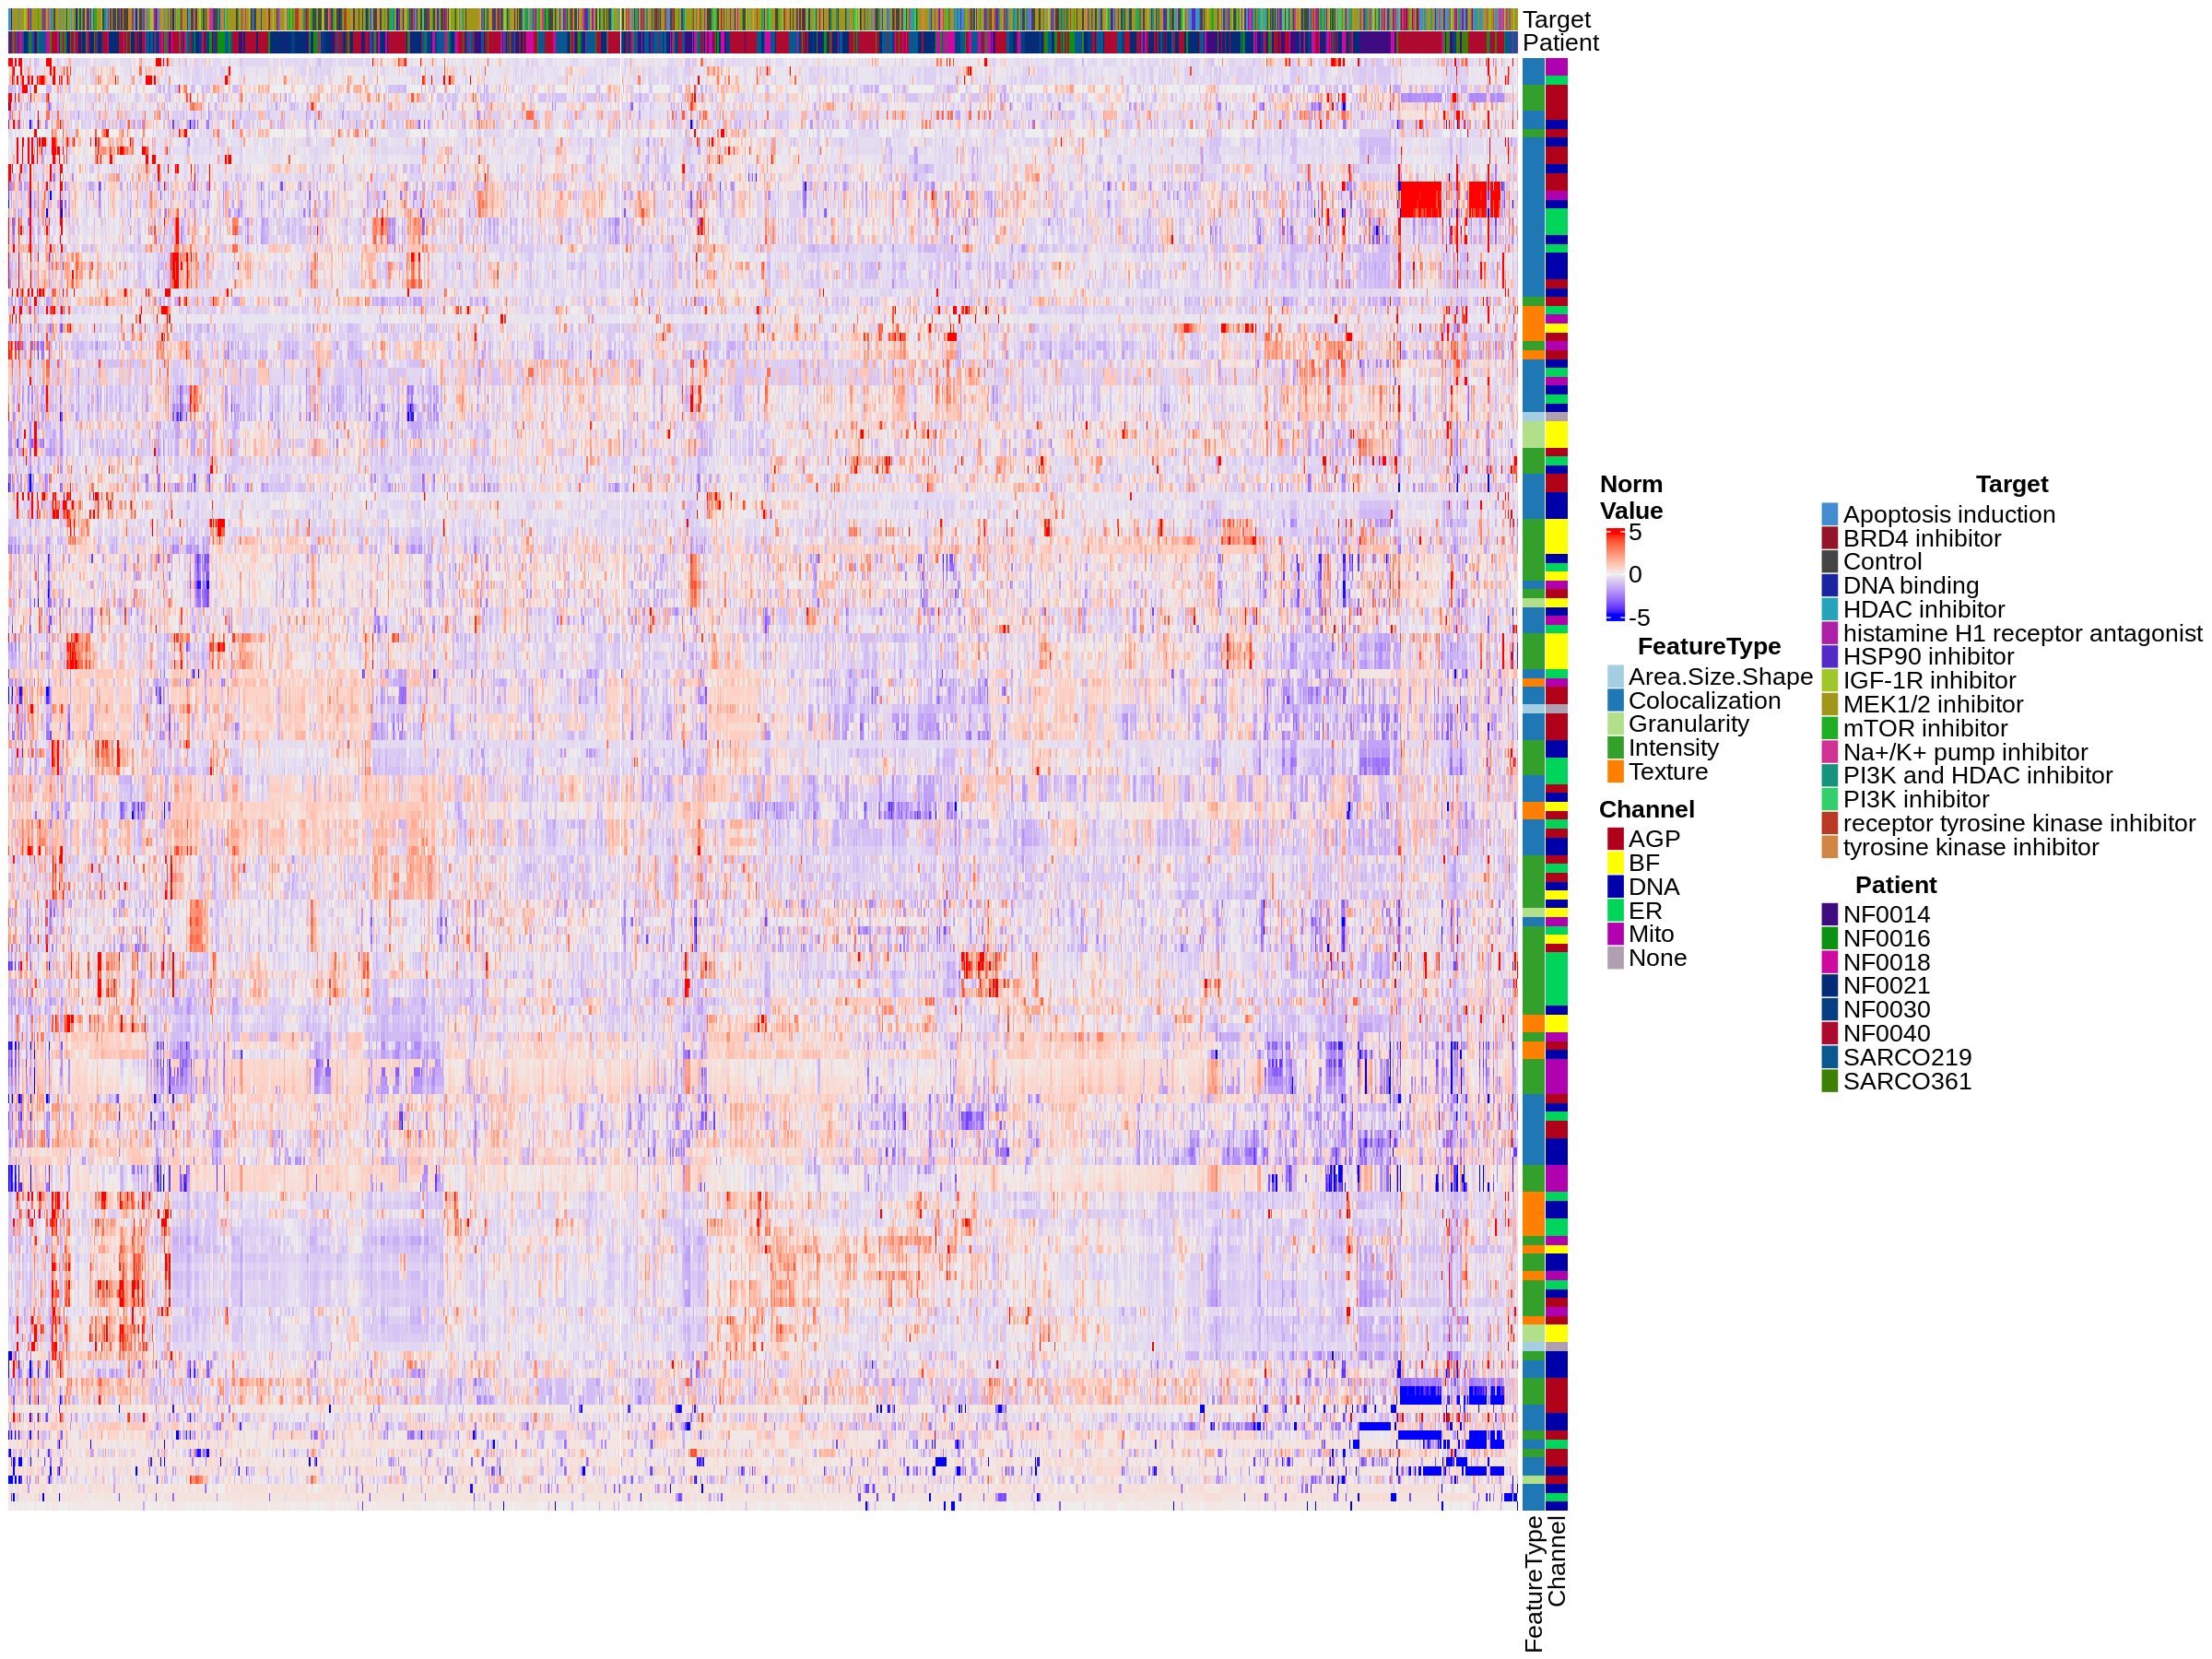

In [35]:
width <- 20
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
heatmap_plot <- Heatmap(
        mat, 
        # col = col_fun,
        show_row_names = FALSE,
        # cluster_columns = FALSE,
        show_column_names = FALSE,
        row_dend_reorder = TRUE, # reorder rows based on dendrogram
        column_dend_reorder = TRUE, # reorder columns based on dendrogram
        show_row_dend = FALSE,
        show_column_dend = FALSE,

        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14), 

        # show_heatmap_legend = FALSE,
        heatmap_legend_param = list(
                    title = "Norm\nValue",
                    title_position = "topcenter", 
                    title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                    labels_gp = gpar(fontsize = 16),
                    # legend_height = unit(2, "cm"),
                    legend_width = unit(3, "cm"),
                    annotation_legend_side = "bottom"
                    ), 
        
        row_dend_width = unit(4, "cm"),
        column_dend_height = unit(4, "cm"),
        # column_title = paste0("Dose: ", dose," uM"),
        right_annotation = row_annotations,
        top_annotation = column_annotations,
        # adjust the title position and size
        column_title_gp = gpar(fontsize = 16, fontface = "bold", hjust = 0.5),
    
    )
png(organoid_fs_heatmap_file_path, width = width, height = height, units = "in", res = 600)
# save as a PNG
draw(heatmap_plot, merge_legend = TRUE, heatmap_legend_side = "right")
dev.off()
heatmap_plot